Este notebook se basa en información de target
![imagen.png](https://www.america-retail.com/static//2020/12/target01.jpg)


Ahora imagina que somos parte del equipo de data science de la empresa Target, una de las tiendas con mayor presencia en Estados Unidos. El departamento de logistica acude a nosotros para saber donde le conviene poner sus almacenes, para que se optimice el gasto de gasolina, los tiempos de entrega de los productos y se disminuyan costos. Para ello, nos pasan los datos de latitud y longitud de cada una de las tiendas.

https://www.kaggle.com/datasets/saejinmahlauheinert/target-store-locations?select=target-locations.csv

Si quieres saber un poco más de graficas geográficas consulta el siguiente notebook
https://colab.research.google.com/github/QuantEcon/quantecon-notebooks-datascience/blob/master/applications/maps.ipynb#scrollTo=uo2oPtSCeAOz

In [163]:
! pip install qeds fiona geopandas xgboost gensim folium pyLDAvis descartes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [164]:
import pandas as pd
import numpy as np
from tqdm import tqdm
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import geopandas

Importa la base de datos

In [165]:
url="https://raw.githubusercontent.com/marypazrf/bdd/main/target-locations.csv"
df=pd.read_csv(url)

Exploremos los datos.

In [166]:

df.head()


,name,latitude,longitude,address,phone,website
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468


In [167]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1839 entries, 0 to 1838
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       1839 non-null   object 
 1   latitude   1839 non-null   float64
 2   longitude  1839 non-null   float64
 3   address    1839 non-null   object 
 4   phone      1839 non-null   object 
 5   website    1839 non-null   object 
dtypes: float64(2), object(4)
memory usage: 86.3+ KB


**Definición de Latitud y Longitud**

**Latitud** Es la distancia en grados, minutos y segundos que hay con respecto al paralelo principal, que es el ecuador (0º). La latitud puede ser norte y sur.

**Longitud**: Es la distancia en grados, minutos y segundos que hay con respecto al meridiano principal, que es el meridiano de Greenwich (0º).La longitud puede ser este y oeste.

In [168]:
latlong=df[["latitude","longitude"]]

¡Visualizemos los datos!, para empezar a notar algún patron. 

A simple vista pudieramos pensar que tenemos algunos datos atípicos u outliers, pero .... no es así, simplemente esta grafica no nos está dando toda la información.

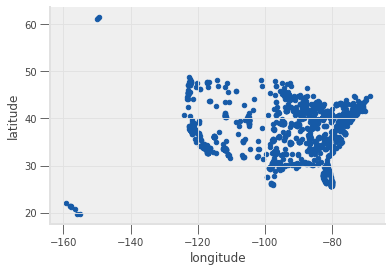

In [169]:
#extrae los datos interesantes
latlong.plot.scatter( "longitude","latitude")

In [170]:
latlong.describe()

,latitude,longitude
count,1839.000000,1839.000000
mean,37.791238,-91.986881
std,5.272299,16.108046
min,19.647855,-159.376962
25%,33.882605,-98.268828
50%,38.955432,-87.746346
75%,41.658341,-80.084833
max,61.577919,-68.742331


Para entender un poco más, nos auxiliaremos de una librería para graficar datos geográficos. Esto nos ayudara a tener un mejor entendimiento de ellos.




In [171]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

from shapely.geometry import Point

%matplotlib inline
# activate plot theme
import qeds
qeds.themes.mpl_style();

In [172]:
df["Coordinates"] = list(zip(df.longitude, df.latitude))
df["Coordinates"] = df["Coordinates"].apply(Point)
df.head()

,name,latitude,longitude,address,phone,website,Coordinates
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276,POINT (-86.80417369999999 33.2242254)
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375,POINT (-86.98977789999999 33.3345501)
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274,POINT (-87.89593169999999 30.6028747)
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084,POINT (-86.9715595 34.5601477)
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468,POINT (-85.4464222 31.2660613)


In [173]:
gdf = gpd.GeoDataFrame(df, geometry="Coordinates")
gdf.head()

,name,latitude,longitude,address,phone,website,Coordinates
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276,POINT (-86.80417 33.22423)
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375,POINT (-86.98978 33.33455)
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274,POINT (-87.89593 30.60287)
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084,POINT (-86.97156 34.56015)
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468,POINT (-85.44642 31.26606)


In [174]:
#mapa

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world.set_index("iso_a3")

world.head()

,pop_est,continent,name,gdp_md_est,geometry
iso_a3,,,,,
FJI,920938,Oceania,Fiji,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
TZA,53950935,Africa,Tanzania,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
ESH,603253,Africa,W. Sahara,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
CAN,35623680,North America,Canada,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
USA,326625791,North America,United States of America,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [175]:
#graficar el mapa
world.name.unique()

array(['Fiji', 'Tanzania', 'W. Sahara', 'Canada',
       'United States of America', 'Kazakhstan', 'Uzbekistan',
       'Papua New Guinea', 'Indonesia', 'Argentina', 'Chile',
       'Dem. Rep. Congo', 'Somalia', 'Kenya', 'Sudan', 'Chad', 'Haiti',
       'Dominican Rep.', 'Russia', 'Bahamas', 'Falkland Is.', 'Norway',
       'Greenland', 'Fr. S. Antarctic Lands', 'Timor-Leste',
       'South Africa', 'Lesotho', 'Mexico', 'Uruguay', 'Brazil',
       'Bolivia', 'Peru', 'Colombia', 'Panama', 'Costa Rica', 'Nicaragua',
       'Honduras', 'El Salvador', 'Guatemala', 'Belize', 'Venezuela',
       'Guyana', 'Suriname', 'France', 'Ecuador', 'Puerto Rico',
       'Jamaica', 'Cuba', 'Zimbabwe', 'Botswana', 'Namibia', 'Senegal',
       'Mali', 'Mauritania', 'Benin', 'Niger', 'Nigeria', 'Cameroon',
       'Togo', 'Ghana', "Côte d'Ivoire", 'Guinea', 'Guinea-Bissau',
       'Liberia', 'Sierra Leone', 'Burkina Faso', 'Central African Rep.',
       'Congo', 'Gabon', 'Eq. Guinea', 'Zambia', 'Malawi', 'M

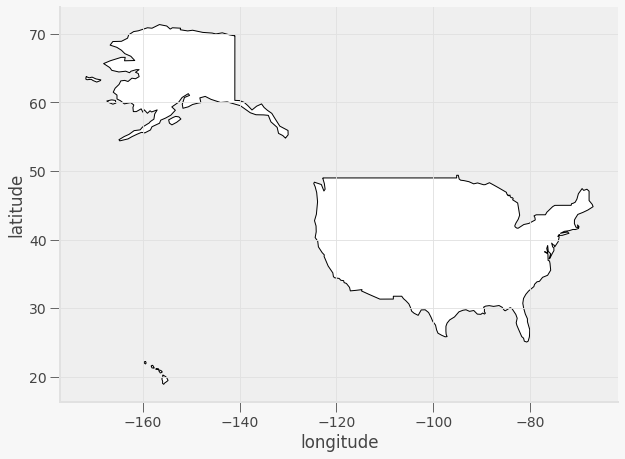

In [176]:
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot SA.
world.query("name == 'United States of America'").plot(ax=gax, edgecolor='black',color='white')

# By the way, if you haven't read the book 'longitude' by Dava Sobel, you should...
gax.set_xlabel('longitude')
gax.set_ylabel('latitude')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

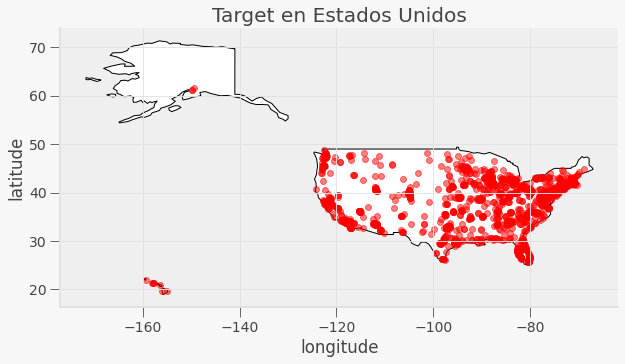

In [177]:
# Step 3: Plot the cities onto the map
# We mostly use the code from before --- we still want the country borders plotted --- and we
# add a command to plot the cities
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot, well,
# South America.
world.query("name == 'United States of America'").plot(ax = gax, edgecolor='black', color='white')

# This plot the cities. It's the same syntax, but we are plotting from a different GeoDataFrame.
# I want the cities as pale red dots.
gdf.plot(ax=gax, color='red', alpha = 0.5)

gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.set_title('Target en Estados Unidos')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

¿qué tal ahora?, tiene mayor sentido verdad, entonces los datos lejanos no eran atípicos, de aquí la importancia de ver los datos con el tipo de gráfica correcta.

Ahora sí, implementa K means a los datos de latitud y longitud :) y encuentra donde colocar los almacenes. 

Nota: si te llama la atención implementar alguna otra visualización con otra librería, lo puedes hacer, no hay restricciones.

In [178]:
from sklearn.cluster import KMeans

In [179]:
latlong

,latitude,longitude
0,33.224225,-86.804174
1,33.334550,-86.989778
2,30.602875,-87.895932
3,34.560148,-86.971559
4,31.266061,-85.446422
...,...,...
1834,43.034293,-88.176840
1835,42.989604,-88.259806
1836,42.846799,-106.264166
1837,41.162019,-104.800048


In [180]:
# initial parameters kmeans algorithm
kmeans = KMeans()
values = np.array(latlong)
kmeans.fit(values)

KMeans()

In [181]:
kmeans.cluster_centers_

array([[  37.56677907, -108.56162352],
       [  41.81607458,  -88.78423449],
       [  40.3424011 ,  -75.65255351],
       [  20.94542771, -157.31225085],
       [  32.40258533,  -95.87017864],
       [  35.43471729, -118.94132621],
       [  31.10736937,  -82.57778027],
       [  46.97944073, -122.66305544]])

In [182]:
kmeans.inertia_

31619.969108674835

In [183]:
kmeans_kwargs = {
    "init":"random",
    "n_init":10,
    "max_iter":300,
    "random_state":42
}

In [184]:
sse =  []
cluster_centers = {}
for k in range(1,11):
  kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
  kmeans.fit(values)
  sse.append(kmeans.inertia_)
  cluster_centers[k] = kmeans.cluster_centers_

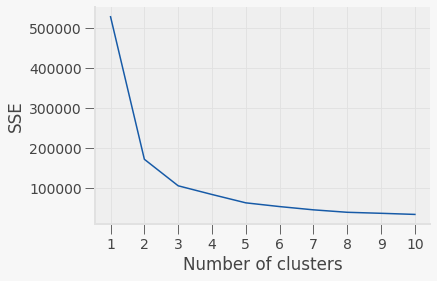

In [185]:
plt.plot(range(1,11), sse)
plt.xticks(range(1,11))
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

In [186]:
cluster_centers[3] # best number of cluster according to the elbow method

array([[  37.9827023 ,  -93.34747643],
       [  37.4817419 , -118.657146  ],
       [  37.789554  ,  -78.56990807]])

In [187]:
kmeans = KMeans(init='random', n_clusters=3, random_state=42)
kmeans.fit(values)

C = pd.DataFrame(kmeans.cluster_centers_)
C['COORDINATES'] = list(zip(C[1], C[0]))
C['COORDINATES'] = C['COORDINATES'].apply(Point)

gdf_C = gpd.GeoDataFrame(C, geometry='COORDINATES')
gdf_C

,0,1,COORDINATES
0,37.982702,-93.347476,POINT (-93.34748 37.98270)
1,37.481742,-118.657146,POINT (-118.65715 37.48174)
2,37.789554,-78.569908,POINT (-78.56991 37.78955)


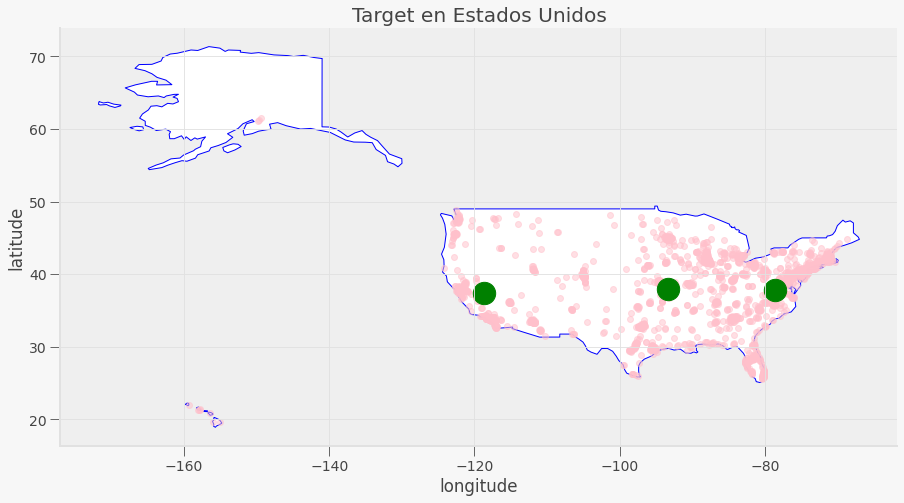

In [188]:
fig, gax = plt.subplots(figsize=(15,10))

world.query("name == 'United States of America'").plot(ax = gax, edgecolor='blue', color='white')

gdf.plot(ax=gax, color='pink', alpha = 0.5) 
gdf_C.plot(ax=gax, color='green', alpha = 1, markersize = 500) 

gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.set_title('Target en Estados Unidos')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

In [189]:
latlong['kmeans'] = kmeans.labels_  
latlong.loc[:, 'kmeans'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


2    827
0    627
1    385
Name: kmeans, dtype: int64

In [209]:
gdf_C[1]

0    -93.347476
1   -118.657146
2    -78.569908
Name: 1, dtype: float64

In [211]:
from pandas.core.internals.concat import concat_arrays

Location1 = str(gdf_C[0][0]) + ", " + str(gdf_C[1][0]) 
print(Location1)
Location2 = str(gdf_C[0][1]) + ", " + str(gdf_C[1][1])
print(Location2)
Location3 = str(gdf_C[0][2]) + ", " + str(gdf_C[1][2])
print(Location3)

37.982702304140126, -93.34747642977707
37.48174189765625, -118.6571460013021
37.789554004474006, -78.56990807484885


In [212]:
from geopy.geocoders.yandex import Location
from geopy.geocoders import Nominatim 
from geopy.distance import geodesic
from geopy.geocoders import ArcGIS

geolocator = ArcGIS(user_agent='my-application')
Locations = [Location1, Location2, Location3] 

for i in Locations:
  location = geolocator.reverse(i)  
  print('Almacén en ---', location.address)

Almacén en --- , Wheatland, Missouri 65779, USA
Almacén en --- Benton Crossing Rd, Bishop, California 93514, USA
Almacén en --- , Esmont, Virginia 22937, USA


In [213]:
distancia1 = str(geodesic(Location1, Location2).miles)
print("\nDistancia entre el primer y segundo almacén : ", distancia1, " ft2 \n") 
distancia2 = str(geodesic(Location2, Location3).miles)
print("Distancia entre el segundo y tercer almacén : ", distancia2, " ml \n")


Distancia entre el primer y segundo almacén :  1382.4721323777403  ft2 

Distancia entre el segundo y tercer almacén :  2181.490837424155  ml 



La manera en la que se eligio el numero de clusters para este problema fue mediante el metodo del 'codo' la cual consiste en probar diferentes numeros de clusters en un inicio y guardar los errores cuadrados de cada uno. Posteriormente se hace una grafica entre el numero de clusters y los errores que tiene cada uno. En cuanto se vea un punto de inflexion en donde el numero de clusters despues de este punto de inflexion ya no se ve una reduccion substancial de los errores, ese punto de inflexion representa el numero optimo de clusters a elegir.

Esta libreria que se utilizo para graficar este tipo de datos geo-espaciales fue muy util porque permite visualizar de manera muy conveniente este tipo de datos. Si existen otro tipo de librerias que puedan manejar este tipo de datos y que se puedan desplegar de forma similar tambien son utiles para este problema. Y la razon por la que es importante graficar los datos en un mapa es porque permite tener un mayor contexto de los datos que se tienen y no catalogarlos incorrectamente como atipicos.